In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import random
import yfinance as yf
from yahoofinancials import YahooFinancials

import torch.optim as optim

from sklearn.model_selection import train_test_split

In [4]:

# Download Apple's stock data
AAPL = yf.download('AAPL', start='2013-01-01', end='2019-12-31', progress=False)

# Select specific columns
selected_data = AAPL[['Open', 'High', 'Low', 'Close', 'Volume']]

# Calculate daily return
selected_data['Daily_Return'] = selected_data['Close'].pct_change()
selected_data = selected_data.dropna() 
#selected_data = selected_data.reset_index(drop=True)

selected_data.head(100)



,Open,High,Low,Close,Volume,Daily_Return
Date,,,,,,
2013-01-03,19.567142,19.631071,19.321428,19.360714,352965200,-0.012622
2013-01-04,19.177500,19.236786,18.779642,18.821428,594333600,-0.027855
2013-01-07,18.642857,18.903570,18.400000,18.710714,484156400,-0.005882
2013-01-08,18.900356,18.996071,18.616072,18.761070,458707200,0.002691
2013-01-09,18.660713,18.750357,18.428213,18.467857,407604400,-0.015629
...,...,...,...,...,...,...
2013-05-21,15.648214,15.910000,15.507143,15.702143,456022000,-0.007383
2013-05-22,15.858929,16.012501,15.650714,15.762500,443038400,0.003844
2013-05-23,15.569643,15.934286,15.563929,15.790714,353021200,0.001790


In [5]:
# Calculate RSI (Relative Strength Index)
def compute_RSI(data, window):
    delta = data.diff(1)
    delta = delta.dropna()

    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    avg_gain = up.rolling(window=window, min_periods=1).mean()
    avg_loss = down.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate KDJ (Stochastic Oscillator)
def compute_KDJ(data, window):
    low_min = data['Low'].rolling(window=window, min_periods=1).min()
    high_max = data['High'].rolling(window=window, min_periods=1).max()

    rsv = (data['Close'] - low_min) / (high_max - low_min) * 100
    K = rsv.ewm(alpha=1/window).mean()
    D = K.ewm(alpha=1/window).mean()
    J = 3 * K - 2 * D
    return K, D, J

# Calculate Accumulation/Distribution Line
def compute_AD_Line(data):
    """
    Calculate Accumulation/Distribution Line

    :param data: DataFrame containing 'Close', 'High', 'Low', 'Volume' columns
    :return: Series of the Accumulation/Distribution Line
    """
    clv = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    clv = clv.fillna(0)  # To prevent division by zero errors
    ad = clv * data['Volume']
    ad_line = ad.cumsum()  # Cumulative sum
    return ad_line

# Add RSI
selected_data['RSI14'] = compute_RSI(selected_data['Close'], 14)

# Add KDJ
selected_data['K9'], selected_data['D9'], selected_data['J9'] = compute_KDJ(selected_data, 9)

# Add EMA (Exponential Moving Average)
selected_data['EMA10'] = selected_data['Close'].ewm(span=10, adjust=False).mean()

# Add Accumulation/Distribution Line
selected_data['A/D'] = compute_AD_Line(selected_data)

selected_data = selected_data.dropna()
selected_data.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'RSI14', 'K9',
       'D9', 'J9', 'EMA10', 'A/D'],
      dtype='object')

In [6]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Assuming selected_data is a Pandas DataFrame
# First, separate features and labels
features = selected_data.drop(['Daily_Return'], axis=1)
labels = selected_data['Daily_Return']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)
train_size = int(len(features) * 0.5)
val_size = int(len(features) * 0.2)
buffer_size = int(len(features) * 0.05)

# Maintaining the continuity of time series data
X_train = features[:train_size]
y_train = labels[:train_size]
X_val = features[train_size + buffer_size : train_size + buffer_size + val_size]
y_val = labels[train_size + buffer_size : train_size + buffer_size + val_size]
X_test = features[train_size + buffer_size * 2 + val_size:]
y_test = labels[train_size + buffer_size * 2 + val_size:]

# Normalize training set features
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)

# Transform validation and test sets using the same normalizer
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bias=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,bias=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,bias=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, 
                                                    dim_feedforward=hidden_size, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.encoder = nn.Linear(input_size, input_size)
        self.decoder = nn.Linear(input_size, output_size)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        if self.src_mask is None or self.src_mask.size(0) != len(x):
            device = x.device
            mask = self._generate_square_subsequent_mask(len(x)).to(device)
            self.src_mask = mask
        
        x = self.encoder(x)
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x, self.src_mask)
        output = self.decoder(output)
        return output

class CustomLossWithVariationPenalty(nn.Module):
    def __init__(self, base_loss, reg_factor=0.01, variation_penalty_factor=1.0, variation_threshold=0.01):
        super().__init__()
        self.base_loss = base_loss
        self.reg_factor = reg_factor
        self.variation_penalty_factor = variation_penalty_factor
        self.variation_threshold = variation_threshold

    def forward(self, outputs, targets):
        # Calculate the base loss (e.g., MSE)
        base_loss = self.base_loss(outputs, targets)
        
        # Calculate the variation in predictions
        variation = torch.abs(outputs[1:] - outputs[:-1])
        
        # Penalize variations smaller than the threshold
        variation_penalty = torch.sum(torch.relu(self.variation_threshold - variation))
        
        # Compute regularization term, penalizing predictions further from zero
        reg_loss = self.reg_factor * torch.sum(torch.abs(outputs))
        
        # Total loss is the sum of base loss and both regularization terms
        total_loss = base_loss + reg_loss + self.variation_penalty_factor * variation_penalty
        return total_loss





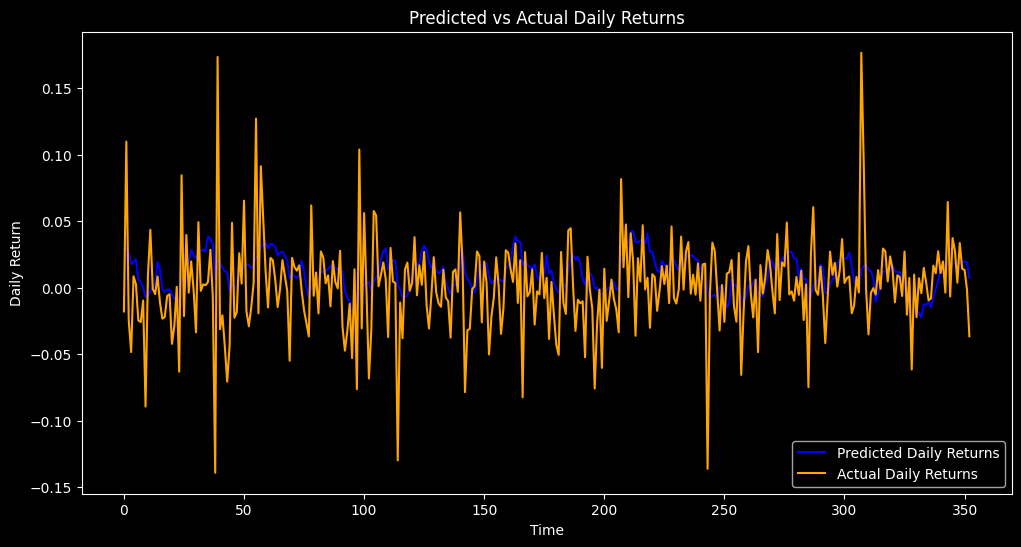

0.15014164


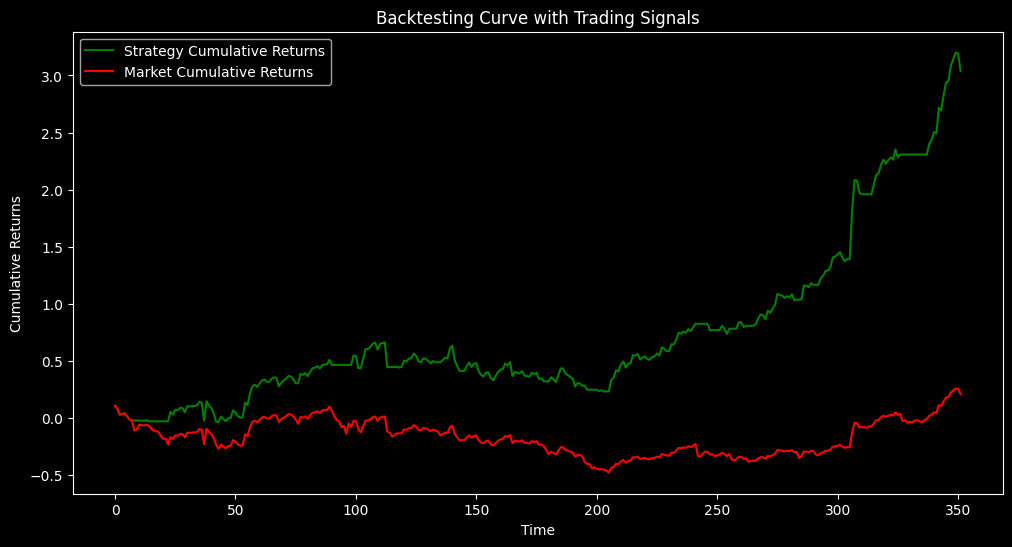

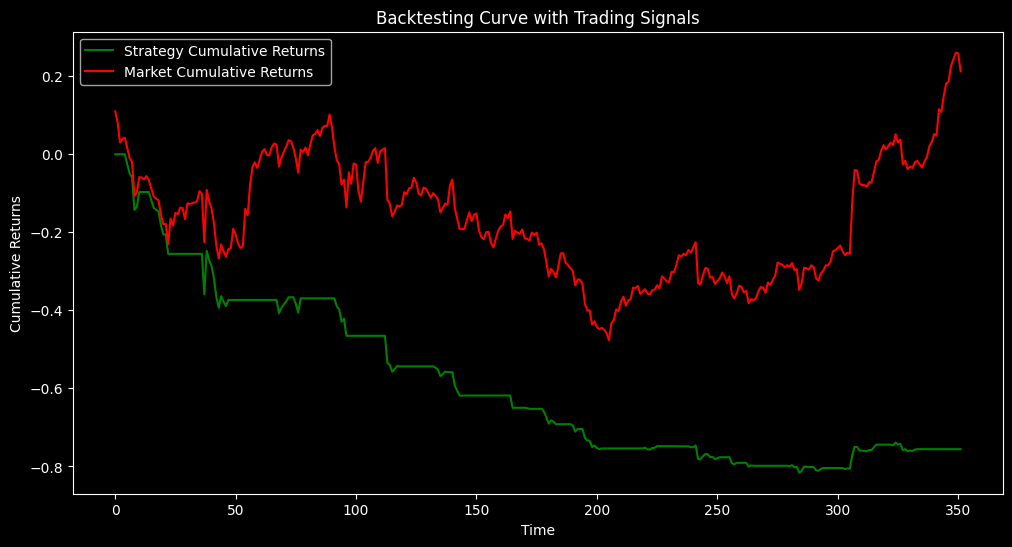

In [ ]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Use a custom loss function
criterion = CustomLossWithVariationPenalty(
    base_loss=nn.MSELoss(), 
    reg_factor=0.01, 
    variation_penalty_factor=0.05, 
    variation_threshold=0.01
)

# Set hyperparameters
input_size = features.shape[1] # Number of features
hidden_size = 64 # Size of the hidden layer
num_layers = 6 # Number of RNN layers
output_size = 1 # Output size, i.e., the predicted daily return

# Create an instance of the model
#model = RNNModel(input_size, hidden_size, num_layers, output_size)
#model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model = GRUModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
# criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32))

# Reshape the data
# Add a dimension to represent the time step
X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape becomes [1406, 1, 20]
print(X_train_tensor.shape)
X_val_tensor = X_val_tensor.unsqueeze(1)
print(X_val_tensor.shape)

# Remaining model training and testing code remains unchanged
num_epochs = 100
for epoch in range(num_epochs):
    # Training mode
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # Evaluation mode
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')


In [220]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Convert test data to torch tensor
X_test_tensor = torch.tensor(X_test.astype(np.float32))

# Reshape test data
X_test_tensor = X_test_tensor.unsqueeze(1)  # Shape becomes [352, 1, 20]
y_test_tensor = torch.tensor(y_test.astype(np.float32))

# Evaluation mode
model.eval()
with torch.no_grad():
    predicted = model(X_test_tensor)
    loss = criterion(predicted.squeeze(), y_test_tensor)
    # print(f'Test Loss: {loss.item():.4f}')

# Assuming predicted and y_test_tensor are already the outputs from the modified model

# Convert the predictions and actual labels back to numpy arrays
predicted_np = predicted.squeeze().numpy()
y_test_np = y_test_tensor.numpy()


/tmp/ipykernel_711816/3051368905.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_tensor = torch.tensor(y_test.astype(np.float32))


In [221]:
cumulative_market_returns = np.cumprod(1 + y_test_np[1:]) - 1

In [ ]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(predicted_np, label='Predicted Daily Returns', color='blue')
plt.plot(y_test_np, label='Actual Daily Returns', color='orange')
plt.title('Predicted vs Actual Daily Returns')
plt.xlabel('Time')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

# Print the mean of the product of signs of predicted and actual returns
print(np.sign(predicted_np * y_test_np).mean())

# Calculate trading signals (1 for buy, 0 for hold)
trading_signals = (predicted_np > 0).astype(int)

# Calculate daily returns of the strategy
strategy_daily_returns = trading_signals[1:] * y_test_np[1:]

# Calculate cumulative returns of the strategy
cumulative_strategy_returns = np.cumprod(1 + strategy_daily_returns) - 1

# Plot the backtesting curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy_returns, label='Strategy Cumulative Returns', color='green')
plt.plot(cumulative_market_returns, label='Market Cumulative Returns', color='red')
plt.title('Backtesting Curve with Trading Signals')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


There are 1509 observations in the training data
There are 251 observations in the test data


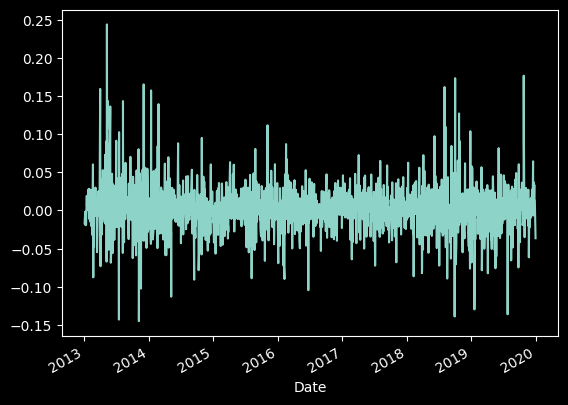

In [39]:
selected_data['Daily_Return'].plot()
print("There are "+ str(selected_data[:'2018'].shape[0]) + " observations in the training data")
print("There are "+ str(selected_data['2019':].shape[0]) + " observations in the test data")

In [95]:
ts_train = selected_data[:'2018']
ts_test  = selected_data['2019':]
ts_train = ts_train.reset_index(drop=True)
ts_test = ts_test.reset_index(drop=True)
ts_test

,Open,High,Low,Close,Volume,Daily_Return
0,20.406668,21.008667,19.920000,20.674667,174879000,-0.068149
1,20.466667,20.626667,19.825333,20.024000,104478000,-0.031472
2,20.400000,21.200001,20.181999,21.179333,110911500,0.057697
3,21.448000,22.449333,21.183332,22.330667,113268000,0.054361
4,22.797333,22.934000,21.801332,22.356667,105127500,0.001164
...,...,...,...,...,...,...
246,27.452000,28.134001,27.333332,27.948000,199794000,0.033605
247,27.890667,28.364668,27.512667,28.350000,120820500,0.014384
248,28.527332,28.898666,28.423332,28.729334,159508500,0.013380
249,29.000000,29.020666,28.407333,28.691999,149185500,-0.001300


In [120]:
def ts_train_test(ts_train, ts_test, time_steps, for_periods, n_splits):
    '''
    input: 
      ts_train: training data as a DataFrame
      ts_test: test data as a DataFrame
      time_steps: number of time steps in the input data
      for_periods: number of periods to forecast
      n_splits: number of splits for cross-validation
    output:
      ts_cv: TimeSeriesSplit object
      X_train, y_train: data for training the model
      X_test, y_test: data for testing the model
      
    '''
    # create training and test set
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Initialize MinMaxScaler
    sc = MinMaxScaler()

    # Fit and Transform the training data
    ts_train = normalize_data(ts_train)
    print(ts_train)
    print('-------------------')
    # Only transform the test data
    ts_test = normalize_data(ts_test)
    print(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    ts_train_numpy = ts_train.to_numpy()
    ts_test_numpy = ts_test.to_numpy()

    for i in range(time_steps, ts_train_len-1): 
        X_train.append(ts_train_numpy[i-time_steps:i, :-1])
        y_train.append(ts_train_numpy[i:i+for_periods, -1])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], ts_train.shape[1] - 1))

    # TimeSeriesSplit
    ts_cv = TimeSeriesSplit(n_splits=n_splits)

    # Prepare the test data
    inputs_test = ts_test.iloc[:, :-1].values

    # Reshape input data to fit the sliding window
    inputs_test_reshaped = np.reshape(inputs_test, (inputs_test.shape[0], inputs_test.shape[1], 1))

    # Prepare X_test
    X_test = []
    for i in range(time_steps, len(inputs_test_reshaped) - for_periods + 1):
        X_test.append(inputs_test_reshaped[i-time_steps:i, :, 0])
    X_test = np.array(X_test)
    y_test = []
    for i in range(time_steps, len(ts_test) - for_periods + 1):
        y_test.append(ts_test.iloc[i:i + for_periods, -1].values)
    y_test = np.array(y_test)

    return ts_cv, X_train, y_train, X_test, y_test

n_splits = 5
ts_cv, X_train, y_train, X_test, y_test = ts_train_test(ts_train, ts_test, 20, 1, n_splits)

X_train.shape[0], X_train.shape[1]


          Open      High       Low     Close    Volume  Daily_Return
0     0.005939  0.005811  0.007603  0.005283  0.008218      0.330022
1     0.004864  0.003986  0.005213  0.004232  0.006366      0.345558
2     0.004864  0.003986  0.005155  0.004061  0.000049      0.368429
3     0.004016  0.003144  0.002880  0.002187  0.022977      0.323507
4     0.002630  0.002274  0.003715  0.002073  0.007020      0.369860
...        ...       ...       ...       ...       ...           ...
1504  0.793021  0.789153  0.757660  0.745491  0.139411      0.176927
1505  0.754843  0.824159  0.754464  0.832685  0.210297      0.640070
1506  0.810950  0.810684  0.775803  0.804397  0.221516      0.294398
1507  0.820169  0.850181  0.824502  0.854781  0.258656      0.517162
1508  0.861712  0.858518  0.844229  0.851742  0.159627      0.364674

[1509 rows x 6 columns]
-------------------
         Open      High       Low     Close    Volume  Daily_Return
0    0.492320  0.516631  0.488491  0.520499  0.333799      

(1488, 20)

In [122]:
selected_data = selected_data.iloc[:,5:]

(231, 20, 5)

In [82]:
# function for min-max normalization of stock
def normalize_data(df):
    sc = MinMaxScaler()
    df['Open'] = sc.fit_transform(df['Open'].values.reshape(-1,1))
    df['High'] = sc.fit_transform(df['High'].values.reshape(-1,1))
    
    
    
    df['Low'] = sc.fit_transform(df['Low'].values.reshape(-1,1))

    df['Close'] = sc.fit_transform(df['Close'].values.reshape(-1,1))
    
    df['Volume'] = sc.fit_transform(df['Volume'].values.reshape(-1,1))
    df['Daily_Return'] = sc.fit_transform(df['Daily_Return'].values.reshape(-1,1))
    return df

